What exactly is the gating mechanism here?

The gate is a single linear layer that sees the concatenation of the backbone embedding h ∈ R^emb_dim, and a user embedding u ∈ R^user_dim (from an embedding table during pretrain, or your PEFT/override at test).

g = Linear([h ; u]) ∈ R^E          # raw gate logits for E experts <br>
w = softmax(g)                      # probs over experts <br>
w = topk_mask(w, k=TOP_K)           # keep only top-k, renormalize <br>

Non-selected experts (masked by top-k) do not receive gradient on that example.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from MOE_model_classes import *
from MOE_quick_cls_heads import *
from MOE_training import *
from diagnostics import *

import os
import sys
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

# Add the parent directory folder to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

from configs.hyperparam_tuned_configs import *
from utils.DNN_FT_funcs import *
#load_expdef_gestures, make_data_split, process_split
from utils.gesture_dataset_classes import *
#from utils.viz_utils.quick_analysis_plots import *
#from utils.full_study_funcs import * 

from utils.global_seed import set_seed
set_seed()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")



The current working directory is: c:\Users\kdmen\Repos\fl-gestures\April_25\MOE
Global seed set to 17


In [2]:
set_seed()

Global seed set to 17


In [3]:

# ===================== MODEL CONFIG ===========================
basicMOE_config = {
    # ----- Identity / IO -----
    "model_str": "MoEClassifier",          # class name
    "backbone_type": "TinyBackbone",
    "feature_engr": "moments",             # keep if your loaders rely on this
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # PRETRAINING
    "num_epochs": 300,
    "batch_size": 64,
    "learning_rate": 7e-05,
    "optimizer": "adamw",
    "weight_decay": 0.0005,
    "lr_scheduler_patience": 7,
    "lr_scheduler_factor": 0.2,
    "earlystopping_patience": 10,
    "earlystopping_min_delta": 0.005,
    "num_train_gesture_trials": NUM_TRAIN_GESTURES,
    "num_pretrain_users": 24,

    # ----- Data shape (maps to TinyBackbone) -----
    "num_channels": 16,                    # -> TinyBackbone.in_ch
    "sequence_length": 5,                  # -> TinyBackbone.seq_len
    "time_steps": 1,                       # legacy (kept for compatibility)

    # ----- Embeddings / dims -----
    "emb_dim": 64,                    # -> TinyBackbone.emb_dim and Expert/keys
    "user_emb_dim": 16,                  # -> user embedding dim

    # ----- Task -----
    "num_classes": 10,

    # ----- MoE layout -----
    "num_experts": 6,            # -> number of Expert heads
    "top_k": 2,                        # -> gating sparsity (None for dense)
    "use_user_table": True,      # -> whether to learn user embedding table
    "gate_type": "user_aware",             # ("user_aware" | "feature_only")
    "gate_dense_before_topk": True,        # softmax then mask (matches code)

    # ----- Expert head (maps to Expert) -----
    "expert_hidden": 64,              # Expert.fc1 hidden = emb_dim
    "expert_dropout": 0.10,           # -> Expert.drop p
    "expert_norm": "layernorm",            # fixed in code; keeping for clarity

    # ----- Prototype / keys -----
    "expert_keys_init_std": 0.1,           # -> nn.Parameter N(0, std^2)

    # ----- Regularization / losses -----
    "label_smooth": 0.05,
    "gate_balance_coef": 0.05,

    # ----- Training / logging -----
    "seed": 17,
    "print_every": 50,
    "user_split_json_filepath": "C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\fixed_user_splits\\24_8_user_splits_RS17.json",
    "results_save_dir": f"C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\results\\MOE\\{timestamp}_MOE",
    "models_save_dir": f"C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\models\\MOE\\{timestamp}_MOE",

    # ----- FINETUNING / PEFT / adaptation -----
    "finetune_strategy": "linear_probing",
    "use_dropout_during_peft": False,
    "ft_learning_rate": 0.001,
    "ft_batch_size": 10,
    "num_ft_epochs": 100,
    "ft_weight_decay": 1e-3,
    "ft_lr_scheduler_patience": 7,
    "ft_lr_scheduler_factor": 0.25,
    "ft_earlystopping_patience": 10,
    "ft_earlystopping_min_delta": 0.003,
    "num_ft_gesture_trials": NUM_FT_GESTURES,
    "num_testft_users": 8,
    "save_ft_models": False,
    "reset_ft_layers": False,

    # MISC
    "cluster_iter_str": 'Iter18',
    "use_earlystopping": True,
    "verbose": False,
    "log_each_pid_results": False, 


    # ===== Legacy CNN/LSTM keys kept for compatibility (NOT IMPLEMENTED) =====
    # "use_batch_norm": False,             # NOT IMPLEMENTED in TinyBackbone/Expert
    # "conv_layers": [[32, 3, 1]],         # NOT IMPLEMENTED
    # "fc_layers": [256],                  # NOT IMPLEMENTED (backbone uses fixed MLP)
    # "fc_dropout": 0.3,                   # NOT IMPLEMENTED
    # "cnn_dropout": 0.0,                  # NOT IMPLEMENTED
    # "dense_cnnlstm_dropout": 0.1,        # NOT IMPLEMENTED
    # "use_dense_cnn_lstm": True,          # NOT IMPLEMENTED
    # "use_layerwise_maxpool": False,      # NOT IMPLEMENTED
    # "pooling_layers": [False],           # NOT IMPLEMENTED
    # "lstm_num_layers": 0,                # NOT IMPLEMENTED
    # "lstm_hidden_size": 0,               # NOT IMPLEMENTED
    # "lstm_dropout": 0.0,                 # NOT IMPLEMENTED
    # "padding": 0,                        # NOT USED
}


In [4]:
MODEL_STR = basicMOE_config["model_str"]
MY_CONFIG = copy.deepcopy(basicMOE_config)

DEVICE = basicMOE_config["device"]


In [5]:
CONFIG_FOR_SPLITS = basicMOE_config

# This is super repeated, consolidate and remove the unnecessary stuff from the other cells
moments_expdef_df = load_expdef_gestures(feateng_method="moments")
moments_data_splits = make_data_split(moments_expdef_df, CONFIG_FOR_SPLITS, split_index=None)  
test_participants = list(np.unique(moments_data_splits['novel_subject_test_dict']['participant_ids']))
all_participants = np.unique(moments_data_splits['pretrain_dict']['participant_ids'] + moments_data_splits['pretrain_subject_test_dict']['participant_ids'] + test_participants)
label_encoder = LabelEncoder()
label_encoder.fit(all_participants)
train_df = process_split(moments_data_splits, 'pretrain_dict', label_encoder)
intra_test_df = process_split(moments_data_splits, 'pretrain_subject_test_dict', label_encoder)
moments_data_dfs_dict = {'pretrain_df':train_df, 'pretrain_subject_test_df':intra_test_df}

Loading in data, with moments feature engineering!


In [6]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

Loading in data, with moments feature engineering!
(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P102,pan,1,"[-0.1964091032249778, -0.3520191722373255, -0....",5,6
1,P102,pan,2,"[-0.0360169757802307, -0.5029028515788563, -0....",5,6
2,P102,pan,3,"[-0.1001860983981701, -0.46837367292591, -0.56...",5,6
3,P102,pan,4,"[-0.060986345793039, -0.480572887435198, -0.66...",5,6
4,P102,pan,5,"[-0.0315063363429103, -0.5235507309772758, -0....",5,6


In [7]:
data_splits = make_data_split(expdef_df, MY_CONFIG, split_index=None)  
# json splits are taken care of here!
# So did I even need to load it earlier? ...

In [8]:
data_splits.keys()

dict_keys(['pretrain_dict', 'pretrain_subject_test_dict', 'novel_trainFT_dict', 'novel_subject_test_dict', 'novel_val_trainFT_dict', 'novel_subject_val_test_dict'])

In [9]:
# If these are arrays/lists (not sets), do this:
train_ids = np.asarray(convert_participant_ids(data_splits['pretrain_dict']['participant_ids']))
val_ids   = np.asarray(convert_participant_ids(data_splits['pretrain_subject_test_dict']['participant_ids']))

# Unique union (no double counting)
all_pretrain_ids = np.unique(np.concatenate([train_ids, val_ids]))
# Ensure sorted & int type (nice-to-have)
all_pretrain_ids = np.sort(all_pretrain_ids.astype(np.int64))

# Build maps
id2idx = {int(u): i for i, u in enumerate(all_pretrain_ids)}
idx2id = all_pretrain_ids.tolist()

num_train_users = len(idx2id)
print(f"[map] {num_train_users} pretrain users -> contiguous [0..{num_train_users-1}]")

encoded_train_ids = [id2idx[my_id] for my_id in train_ids]
encoded_val_ids = [id2idx[my_id] for my_id in val_ids]


[map] 24 pretrain users -> contiguous [0..23]


In [10]:
train_dataset = make_tensor_dataset(data_splits['pretrain_dict']['feature'], data_splits['pretrain_dict']['labels'], MY_CONFIG, participant_ids=encoded_train_ids)
train_loader = DataLoader(train_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)

val_dataset = make_tensor_dataset(data_splits['pretrain_subject_test_dict']['feature'], data_splits['pretrain_subject_test_dict']['labels'], MY_CONFIG, participant_ids=encoded_val_ids)
val_loader = DataLoader(val_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)



In [11]:
num_train_users = len(set(data_splits['pretrain_dict']['participant_ids']))

In [12]:
model = MoEClassifier(MY_CONFIG).to(MY_CONFIG["device"])

In [13]:
# Make sure this matches the embedding size you passed to MoEClassifier:
#print("num_train_users =", num_train_users)
#
#debug_one_batch(model, train_loader, device=DEVICE,
#                num_classes=NUM_CLASSES, num_users_train=num_train_users)


### Pretrain the model

In [14]:
model, logs = moe_pretrain(model, MY_CONFIG, train_loader, val_loader)


[epoch] avg_usage=[0.32899999618530273, 0.2770000100135803, 0.024000000208616257, 0.0010000000474974513, 0.06599999964237213, 0.30300000309944153]  entropy=1.357 (target≈1.792)  KL=1.099
[epoch 001] train: loss=2.3813 acc=0.105 | val: loss=2.3236 acc=0.115
[epoch] avg_usage=[0.36000001430511475, 0.2669999897480011, 0.020999999716877937, 0.0010000000474974513, 0.052000001072883606, 0.29899999499320984]  entropy=1.321 (target≈1.792)  KL=1.151
[epoch 002] train: loss=2.3265 acc=0.137 | val: loss=2.2809 acc=0.133
[epoch] avg_usage=[0.38100001215934753, 0.25999999046325684, 0.01899999938905239, 0.0010000000474974513, 0.04100000113248825, 0.296999990940094]  entropy=1.295 (target≈1.792)  KL=1.079
[epoch 003] train: loss=2.2876 acc=0.161 | val: loss=2.2470 acc=0.152
[epoch] avg_usage=[0.3889999985694885, 0.25699999928474426, 0.019999999552965164, 0.003000000026077032, 0.03400000184774399, 0.296999990940094]  entropy=1.288 (target≈1.792)  KL=0.980
[epoch 004] train: loss=2.2472 acc=0.186 | val

In [15]:
# --- evaluate on pretrain val for sanity ---
val_loss, val_acc = evaluate(model, val_loader, device=DEVICE)
print(f"[val] loss={val_loss:.4f} acc={val_acc:.3f}")

[val] loss=0.3865 acc=0.900


### Transfer Learning Finetuning

In [16]:
# Can I use this directly? I don't see why not if I have the dataloaders
## I don't have a config defined tho...
## I ought to make one FWIW

# This func is from my DNN_FT.py which is imported above
#def fine_tune_model(finetuned_model, fine_tune_loader, config, timestamp, test_loader=None, pid=None, num_epochs=None):  #use_earlystopping=None,



[novel user P010] adapting with 10 samples


c:\Users\kdmen\Repos\fl-gestures\April_25\utils\gesture_dataset_classes.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(x, dtype=dtype)


FT : Early stopping reached after 52 epochs
[novel user P010] query loss=2.8377 acc=0.233


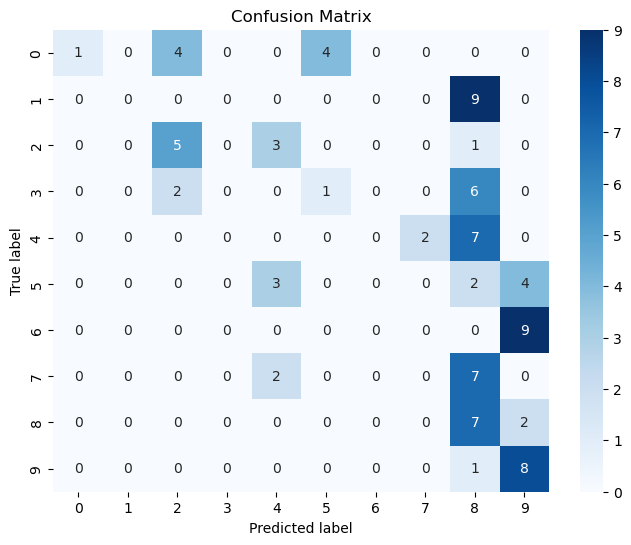

c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.00      0.00      0.00         9
           2       0.45      0.56      0.50         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.17      0.78      0.29         9
           9       0.35      0.89      0.50         9

    accuracy                           0.23        90
   macro avg       0.20      0.23      0.15        90
weighted avg       0.20      0.23      0.15        90



[novel user P116] adapting with 10 samples
FT : Early stopping reached after 41 epochs
[novel user P116] query loss=3.2714 acc=0.144


[novel user P127] adapting with 10 samples
FT : Early stopping reached after 17 epochs
[novel user P127]

In [17]:
# --- adapt/evaluate per novel user using your separate loaders ---
results = {}
for user_key in set(data_splits['novel_trainFT_dict']['participant_ids']):
    user_model_inst = copy.deepcopy(model)

    subj_spec_support_dict = filter_by_participant(data_splits['novel_trainFT_dict'], user_key)   # ~10 shots total
    subj_spec_query_dict   = filter_by_participant(data_splits['novel_subject_test_dict'], user_key) # test set for that user

    subj_spec_support_dataset = make_tensor_dataset(subj_spec_support_dict['feature'], subj_spec_support_dict['labels'], MY_CONFIG)
    # TODO: Technically I should be using ft_batch_size here... idk if it matters that much...
    subj_spec_support_loader = DataLoader(subj_spec_support_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    subj_spec_query_dataset = make_tensor_dataset(subj_spec_query_dict['feature'], subj_spec_query_dict['labels'], MY_CONFIG)
    subj_spec_query_loader = DataLoader(subj_spec_query_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    print(f"\n[novel user {user_key}] adapting with {len(subj_spec_support_dataset)} samples")
    ft_res_dict = fine_tune_model(user_model_inst, subj_spec_support_loader, MY_CONFIG, timestamp, test_loader=subj_spec_query_loader, pid=None, num_epochs=None)

    # What happens when user_embed_override is None? Does this work as expected? Review what exactly this is trying to do
    test_loss, test_acc = evaluate(user_model_inst, subj_spec_query_loader, device=DEVICE)#, user_embed_override=u_embed)
    print(f"[novel user {user_key}] query loss={test_loss:.4f} acc={test_acc:.3f}")
    results[user_key] = {"loss": test_loss, "acc": test_acc}

    # Only print this for the first user
    if user_key == data_splits['novel_trainFT_dict']['participant_ids'][0]:
        report_user(user_model_inst, subj_spec_query_loader, device=DEVICE, y_names=None, user_embed=None)
    print()

if results:
    mean_acc = np.mean([v["acc"] for v in results.values()])
    print(f"\n[summary] novel users mean acc = {mean_acc:.3f}")


In [18]:
results


{'P010': {'loss': 2.8377021418677435, 'acc': 0.23333333333333334},
 'P116': {'loss': 3.2714287175072565, 'acc': 0.14444444444444443},
 'P127': {'loss': 3.5794785817464194, 'acc': 0.08888888888888889},
 'P108': {'loss': 3.3879948721991644, 'acc': 0.08888888888888889},
 'P128': {'loss': 2.8285902871025934, 'acc': 0.1111111111111111},
 'P104': {'loss': 2.6920117139816284, 'acc': 0.3111111111111111},
 'P125': {'loss': 2.2835858596695795, 'acc': 0.36666666666666664},
 'P103': {'loss': 3.2221693197886148, 'acc': 0.15555555555555556}}

### PEFT (User Conditioning Vector)


[novel user P010] adapting with 10 samples
[novel user P010] query loss=3.6023 acc=0.100


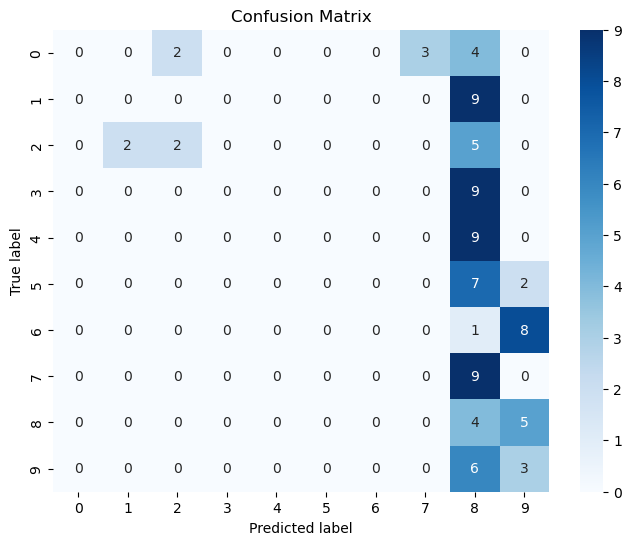

c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         9
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.06      0.44      0.11         9
           9       0.17      0.33      0.22         9

    accuracy                           0.10        90
   macro avg       0.07      0.10      0.06        90
weighted avg       0.07      0.10      0.06        90



[novel user P116] adapting with 10 samples
[novel user P116] query loss=3.6094 acc=0.122


[novel user P127] adapting with 10 samples
[novel user P127] query loss=3.6221 acc=0.111


[novel user P108] adapting with 10 samples
[novel user P1

In [19]:
# --- adapt/evaluate per novel user using your separate loaders ---
results = {}
for user_key in set(data_splits['novel_trainFT_dict']['participant_ids']):
    user_model_inst = copy.deepcopy(model)

    subj_spec_support_dict = filter_by_participant(data_splits['novel_trainFT_dict'], user_key)   # ~10 shots total
    subj_spec_query_dict   = filter_by_participant(data_splits['novel_subject_test_dict'], user_key) # test set for that user

    subj_spec_support_dataset = make_tensor_dataset(subj_spec_support_dict['feature'], subj_spec_support_dict['labels'], MY_CONFIG)
    # TODO: Technically I should be using ft_batch_size here... idk if it matters that much...
    subj_spec_support_loader = DataLoader(subj_spec_support_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    subj_spec_query_dataset = make_tensor_dataset(subj_spec_query_dict['feature'], subj_spec_query_dict['labels'], MY_CONFIG)
    subj_spec_query_loader = DataLoader(subj_spec_query_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    print(f"\n[novel user {user_key}] adapting with {len(subj_spec_support_dataset)} samples")
    u_embed, peft_logs = peft_user_emb_vec(user_model_inst, subj_spec_support_loader, MY_CONFIG)
    test_loss, test_acc = evaluate(user_model_inst, subj_spec_query_loader, device=DEVICE, user_embed_override=u_embed)
    print(f"[novel user {user_key}] query loss={test_loss:.4f} acc={test_acc:.3f}")
    results[user_key] = {"loss": test_loss, "acc": test_acc}

    # Only print this for the first user
    if user_key == data_splits['novel_trainFT_dict']['participant_ids'][0]:
        report_user(user_model_inst, subj_spec_query_loader, device=DEVICE, y_names=None, user_embed=None)
    print()

if results:
    mean_acc = np.mean([v["acc"] for v in results.values()])
    print(f"\n[summary] novel users mean acc = {mean_acc:.3f}")


In [20]:
results

{'P010': {'loss': 3.6022519800398083, 'acc': 0.1},
 'P116': {'loss': 3.6093960073259144, 'acc': 0.12222222222222222},
 'P127': {'loss': 3.622050311830309, 'acc': 0.1111111111111111},
 'P108': {'loss': 3.4443455007341175, 'acc': 0.1},
 'P128': {'loss': 3.0587346288892956, 'acc': 0.044444444444444446},
 'P104': {'loss': 3.6154187785254583, 'acc': 0.2},
 'P125': {'loss': 2.811742809083727, 'acc': 0.18888888888888888},
 'P103': {'loss': 3.50908801290724, 'acc': 0.06666666666666667}}

### Baseline Classifiers
> Use just the shallow embedding network, NOT the actual MOE portion

In [21]:
# ---------- Run on your novel users ----------
proto_results = {}
ridge_results = {}

for user_key in np.unique(data_splits['novel_trainFT_dict']['participant_ids']):
    subj_spec_support_dict = filter_by_participant(data_splits['novel_trainFT_dict'], user_key)   # ~10 shots total
    subj_spec_query_dict   = filter_by_participant(data_splits['novel_subject_test_dict'], user_key) # test set for that user

    subj_spec_support_dataset = make_tensor_dataset(subj_spec_support_dict['feature'], subj_spec_support_dict['labels'], MY_CONFIG)
    # TODO: Technically I should be using ft_batch_size here... idk if it matters that much...
    subj_spec_support_loader = DataLoader(subj_spec_support_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    subj_spec_query_dataset = make_tensor_dataset(subj_spec_query_dict['feature'], subj_spec_query_dict['labels'], MY_CONFIG)
    subj_spec_query_loader = DataLoader(subj_spec_query_dataset, batch_size=MY_CONFIG["ft_batch_size"], shuffle=True)

    proto_acc = proto_eval_user(copy.deepcopy(model), subj_spec_support_loader, subj_spec_query_loader, MY_CONFIG, tau=0.5)
    # try a couple of regularizations quickly
    ridge_accs = []
    for reg in (0.1, 1.0, 10.0):
        ridge_accs.append(ridge_eval_user(copy.deepcopy(model), subj_spec_support_loader, subj_spec_query_loader, MY_CONFIG, reg=reg))
    ridge_best = max(ridge_accs)
  
    # Only print for first user
    if user_key == data_splits['novel_trainFT_dict']['participant_ids']:
        report_user(copy.deepcopy(model), subj_spec_query_loader, DEVICE, y_names=None, user_embed=None)

    proto_results[user_key] = proto_acc
    ridge_results[user_key] = ridge_best
    print(f"[user {user_key}] Proto={proto_acc:.3f} | Ridge(best)={ridge_best:.3f}")

if proto_results:
    print("\n[Proto] mean acc:", np.mean(list(proto_results.values())))
if ridge_results:
    print("[Ridge] mean acc:", np.mean(list(ridge_results.values())))

[user P010] Proto=0.733 | Ridge(best)=0.800
[user P103] Proto=0.722 | Ridge(best)=0.700
[user P104] Proto=0.767 | Ridge(best)=0.767
[user P108] Proto=0.478 | Ridge(best)=0.544
[user P116] Proto=0.767 | Ridge(best)=0.833
[user P125] Proto=0.778 | Ridge(best)=0.867
[user P127] Proto=0.567 | Ridge(best)=0.567
[user P128] Proto=0.844 | Ridge(best)=0.811

[Proto] mean acc: 0.706944465637207
[Ridge] mean acc: 0.7361111268401146


In [22]:
assert(False)

AssertionError: 

In [ ]:
#(iii) FiLM adapter PEFT (tiny but powerful)
#Adapt only a per-user affine on the backbone embedding (and optionally keep your user-embed):

class UserFilm(nn.Module):
    def __init__(self, emb_dim): super().__init__(); 
    def __init__(self, emb_dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, emb_dim))
        self.beta  = nn.Parameter(torch.zeros(1, emb_dim))
    def forward(self, h): return self.gamma * h + self.beta

#During PEFT:
#Freeze model.
#Optimize {film.gamma, film.beta} (+ optional u_user) with LR 1e-2, WD 1e-3, 80–120 steps, eval() mode.
#Replace h = model.backbone(x) by h = film(model.backbone(x)) before gating/experts.